# Chignolin analysis

## Setup

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

## Load Data

In [2]:
from stateinterpreter import load_dataframe

data_path = '../../data/md_datasets/chignolin-biased/'

multiple_walkers = 8
colvar_file = [ data_path + f'COLVAR.{i}' for i in range(multiple_walkers) ] 

start = 10000
stop = 350000
stride = 10

#Load Collective Variables
colvar = load_dataframe(colvar_file, start=start, stop=stop, stride=stride) #.drop(['time'], axis=1)
colvar = colvar.rename(columns={'deep.node-4': 'DeepTICA 1','deep.node-3': 'DeepTICA 2','deep.node-2': 'DeepTICA 3', 'deep.node-1': 'DeepTICA 4','deep.node-0': 'DeepTICA 5'})

## Compute descriptors

In [3]:
from stateinterpreter import load_trajectory
from stateinterpreter.descriptors import compute_descriptors

n_walkers = 8
traj_dict = {
        'trajectory' : [data_path+f'traj_comp_wrap/traj_comp.{i}.xtc' for i in range(n_walkers)],
        'topology' : data_path+'chignolin-ref.pdb'
    }

start, stop, stride = 10000, 350000, 10
traj = load_trajectory(traj_dict,start,stop,stride)
descriptors, feats_info = compute_descriptors( traj, descriptors = ['hbonds_contacts','dihedrals'] )

Computing Hydrogen bonds contacts
Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 144, 157]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 144 157 164 165]
Descriptors: (272000, 420)


## Reweighting 



In [4]:
#------------- PARAMETERS -------------
multicanonical    = True
temp              = 340.
temp0             = 340.
#--------------------------------------

# Calculate inverse temperature
kb=0.008314
beta=1./(kb*temp)
beta0=1./(kb*temp0)

# Extract cvs from df

t = colvar['time'].values # save time
ene = colvar['ene'].values.astype(np.float64) # store energy as long double
bias = colvar.filter(regex='.bias').values.sum(axis=1) # Load *.bias columns and sum them

# Compute log-weights for time reweighting
logweights = beta*bias

if multicanonical:
    ene -= np.mean(ene) #first shift energy by its mean value
    logweights += (beta0-beta)*ene

## Plot FES

In [5]:
from stateinterpreter.metastable import identify_metastable_states

cv_list_2d = ['DeepTICA 1', 'DeepTICA 2']
kBT = 2.8
bandwidth=0.075
states_labels_2d = identify_metastable_states(colvar, cv_list_2d, kBT, logweights=logweights, bandwidth=bandwidth, optimizer_kwargs={'num_init' : 50}, fes_cutoff=kBT)

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 4 local minima with selected populations:
	Basin 0 -> 48710 configurations.
	Basin 1 -> 22866 configurations.
	Basin 2 -> 8313 configurations.
	Basin 3 -> 14268 configurations.


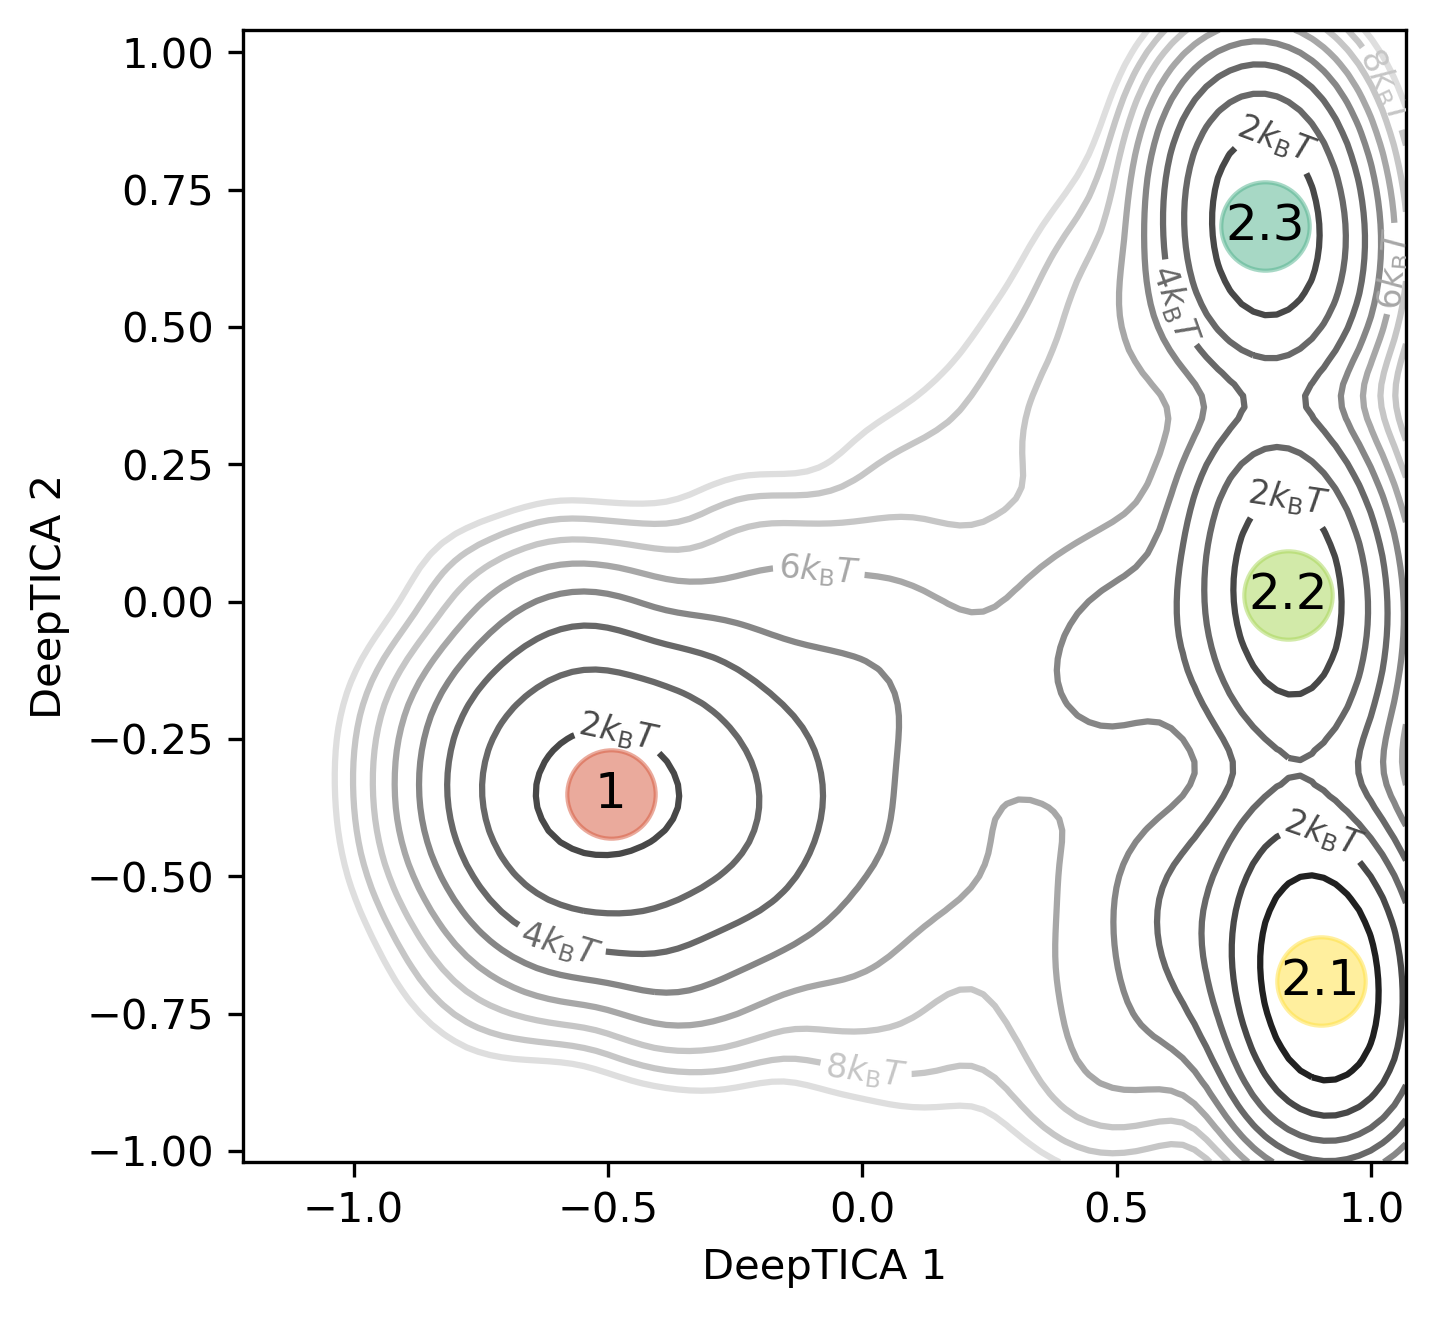

In [6]:
from stateinterpreter.utils.plot import plot_fes_2d,paletteFessa

### PLOT FIGURE        

fig,ax = plt.subplots(dpi=300,figsize=(5,5))

plot_fes_2d( colvar, states_labels_2d, cv_list_2d, save_folder=None, **{'logweights':logweights, 'bandwidth' : bandwidth }, ax = ax, 
                xlim=(-1,1.05),ylim=(-1,1.05), label_names = ['1','2.1','2.2','2.3' ], label_colors= [paletteFessa[6],paletteFessa[4],paletteFessa[3],paletteFessa[2] ]);
plt.show()

## Identify metastable states (hierarchical search)

/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/utils/hierarchical.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  logweight = logweights[[parent_mask]]


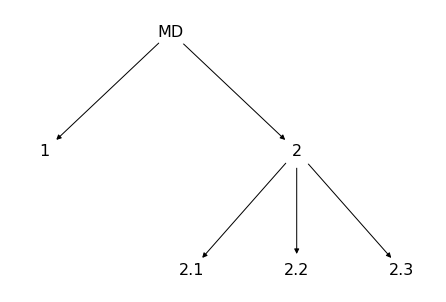

In [7]:
from stateinterpreter.utils.hierarchical import state_tree,hierarchy_pos,generate_state_labels_from_tree

cvs = colvar[['DeepTICA 1','DeepTICA 2']].values
bandwidth = 0.075

# build tree of metastable states
T = state_tree(cvs, bandwidth,logweights=logweights)

# draw tree
pos = hierarchy_pos(T)
options = {
    "with_labels": True,
    "font_size": 16,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "white",
    "linewidths": 1,
    "width": 1,
}

nx.draw(T, pos, **options)

In [8]:
# generate state_labels for classification
labels_list = generate_state_labels_from_tree(T, root='MD', fes_threshold=1 ) 

# example of labels 
labels_list[0]

,labels,selection
0,1,False
1,1,True
2,1,True
3,1,True
4,1,True
...,...,...
271995,2,True
271996,2,True
271997,2,True
271998,2,True


## Train classifier

Training helper function

In [9]:
from stateinterpreter import identify_metastable_states,prepare_training_dataset,Classifier
from stateinterpreter.utils.plot import plot_classifier_complexity_vs_accuracy,plot_histogram_features
from stateinterpreter.utils.plot import paletteFessa,plot_fes
from stateinterpreter.utils.metrics import get_basis_quality,get_best_reg
from itertools import cycle
import matplotlib

def train(cv_list,descriptors,states_labels=None,mask=None,merge_states=None,states_subset=None,color=None):
    # apply mask if given
    if mask is not None:
        cv = colvar[mask].reset_index()
        desc = descriptors[mask].reset_index()
        logw = None
        if logweights is not None:
            logw = logweights[mask]
            if type(logw) == pd.DataFrame:
                logw = logw.reset_index()
    else:
        cv = colvar
        desc = descriptors
        logw = logweights

    ### identify states if states_labels is None
    if states_labels is None:
        states_labels = identify_metastable_states(cv, cv_list, kBT, bandwidth, logweights=logw, fes_cutoff=kBT, gradient_descent_iterates=gradient_descent_iterates)
    
    # merge states if requested 
    if merge_states is not None:
        for pair in merge_states:
            states_labels.loc[states_labels['labels'] == pair[1], 'labels'] = pair[0]
    
    # classify
    sample_obj, features_names = prepare_training_dataset(desc, states_labels, num_samples, regex_filter=select_feat , states_subset=states_subset) 
    classifier = Classifier(sample_obj, features_names)
    classifier.compute(regularizers, max_iter= 10000) #, groups=groups)

    # get best reg
    reg,acc,num = get_best_reg(classifier)
    print(f'log_10 (lambda) : {np.round(np.log10(reg),3)}')
    print(f'Accuracy        : {np.round(acc*100,0)} %')
    print(f'No. features    : {num}')

    # get basis quality
    quality = get_basis_quality(classifier)
    print(f'Basis quality   : {quality} (lower the better)')

    # count states
    num_states = len(classifier.classes)
    num_histo = num_states if num_states>2 else 1
    
    # classes names
    relevant_feat = classifier.feature_summary(reg)
    classes_names = classifier.classes

    fig = plt.figure(figsize=(13.5,3), constrained_layout=True)
    gs = matplotlib.gridspec.GridSpec(num_histo, 3, figure=fig)
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[:, 1])
    axs_histo = []
    for i in range(num_histo):
        axs_histo.append(fig.add_subplot(gs[i, 2]))
    ax = ax1

    # COLOR 
    if color is None:
        colors = cycle(iter(paletteFessa[::-1]))
        global global_states_no 
        for i in range(global_states_no):
            next(colors)
        color = [next(colors) for i in range(5)]

    # PLOT FES
    cv_plot = cv [states_labels['labels'] != 'undefined']
    logw_plot=None
    if logw is not None:
        logw_plot = logw[states_labels['labels'] != 'undefined']
    plot_fes(cv_plot[cv_list],bandwidth,states_labels,logweights=logw_plot,num_samples=200,states_subset=states_subset,ax=ax, colors=color)

    # plot classfier
    ax = ax2
    _, ax_twin = plot_classifier_complexity_vs_accuracy(classifier, ax = ax)
    ax.axvline(np.log10(reg),linestyle='dotted',color='k')
    ax.text(np.log10(reg)+0.02,acc+.05,f'{np.round(acc*100,1)}%',fontsize=12,color='fessa0')
    ax_twin.text(np.log10(reg)+0.02,num+0.5,f'{num}',fontsize=12,color='fessa1')

    #print features
    classifier.print_selected(reg)
    
    plot_histogram_features(desc, states_labels, classes_names, relevant_feat, axs = axs_histo, height=1, colors=color)

    # INCREASE COUNTER
    global_states_no += num_states

    return (cv_list,states_labels,features_names,classifier,reg)

Choose descriptors

In [12]:
# HBONDS
feat_type = 'hbonds'
select_feat = 'HB_C'
filter_descriptors = False 

# Select only contacts which are greater than 0.5 at least once for these states
if filter_descriptors:
    selected = ((descriptors.filter(regex=select_feat)>0.5).sum()>0)
    desc = descriptors[selected.index[selected]]
    print('Filtering H-bonds:',desc.shape)
else:
    desc = descriptors.filter(regex=select_feat)
    print('Descriptors:',desc.shape)
    
desc.head()

Descriptors: (272000, 318)


,HB_C TYR1-N -- TYR2-N,HB_C TYR1-N -- TYR2-OHs,HB_C TYR1-N -- TYR2-O,HB_C TYR1-N -- ASP3-N,HB_C TYR1-N -- ASP3-OD1s,HB_C TYR1-N -- ASP3-OD2s,HB_C TYR1-N -- ASP3-O,HB_C TYR1-N -- PRO4-N,HB_C TYR1-N -- PRO4-O,HB_C TYR1-N -- GLU5-N,...,HB_C TRP9-N -- TYR10-N,HB_C TRP9-N -- TYR10-OHs,HB_C TRP9-N -- TYR10-O,HB_C TRP9-N -- TYR10-OXTs,HB_C TRP9-NE1s -- TYR10-N,HB_C TRP9-NE1s -- TYR10-OHs,HB_C TRP9-NE1s -- TYR10-O,HB_C TRP9-NE1s -- TYR10-OXTs,HB_C TRP9-O -- TYR10-N,HB_C TRP9-O -- TYR10-OHs
0,0.378519,0.003095,0.029586,0.024158,0.012599,0.076158,0.002686,0.002010,0.000607,0.000361,...,0.715437,0.001344,0.053828,0.036315,0.014793,0.000168,0.003120,0.003051,0.945089,0.004376
1,0.390332,0.003598,0.056026,0.015654,0.005961,0.019361,0.002521,0.001574,0.000501,0.000464,...,0.793001,0.001297,0.076325,0.058359,0.015272,0.000183,0.002195,0.002980,0.922969,0.004600
2,0.358987,0.001722,0.028405,0.016784,0.020251,0.004217,0.002936,0.001473,0.000451,0.000514,...,0.608690,0.001415,0.026856,0.030029,0.017289,0.000185,0.003157,0.004451,0.928323,0.004445
3,0.481659,0.002144,0.046059,0.024111,0.011644,0.002872,0.003747,0.002410,0.000696,0.000459,...,0.545835,0.013460,0.028147,0.041351,0.022353,0.000855,0.006566,0.006009,0.939064,0.012201
4,0.427824,0.002328,0.037017,0.012835,0.007647,0.021964,0.001636,0.001736,0.000471,0.000283,...,0.490263,0.003589,0.021301,0.025524,0.025786,0.000329,0.003137,0.005221,0.924722,0.009206


In [ ]:
# ANGLES
feat_type = 'angles'
select_feat = 'sin_|cos_'

desc = descriptors.filter(regex=select_feat)
print('Descriptors:',desc.shape)
desc.head()

Train a classifier for each set of labels in `labels_list`

In [13]:
regularizers = np.geomspace(0.01, 1, 51)
num_samples = 10000 # per metastable state

Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:07<00:00,  6.54it/s]


log_10 (lambda) : -0.32
Accuracy        : 99.0 %
No. features    : 1
Basis quality   : 1 (lower the better)
Accuracy: 99%
State 2:
 HB_C TYR1-O -- TYR10-N


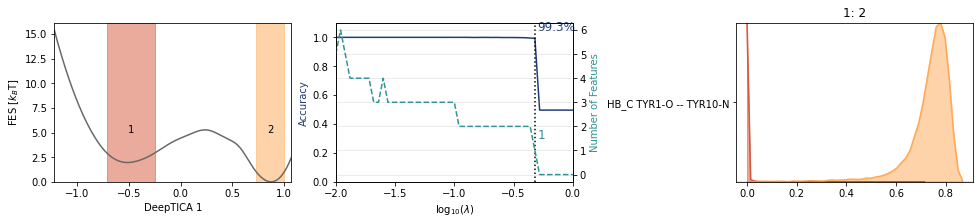

In [14]:
global_states_no = 0 # count number of state to increment color (if not overriden)
results_list = [] # append the results of each classification for further analysis

# DeepTICA 1

states_labels = labels_list[0]
states_subset = states_labels['labels'].unique()
states_subset = states_subset[states_subset != 'undefined' ]

cv_level = states_subset[0].count('.')+1
cv_list = [f'DeepTICA {cv_level}']

subset=['1','2']
colors = [paletteFessa[6],paletteFessa[5]]
result = train(cv_list,desc,states_labels=states_labels,states_subset=subset,color=colors)
results_list.append(result)
plt.show()

Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:06<00:00,  7.47it/s]


log_10 (lambda) : -1.04
Accuracy        : 96.0 %
No. features    : 2
Basis quality   : 8 (lower the better)


/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/utils/plot.py:398: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Min = cv[mask].min().values[0]
/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/utils/plot.py:399: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Max = cv[mask].max().values[0]


Accuracy: 96%
State 2.2:
 HB_C THR6-OG1s -- THR8-OG1s
 HB_C THR6-OG1s -- GLY7-N


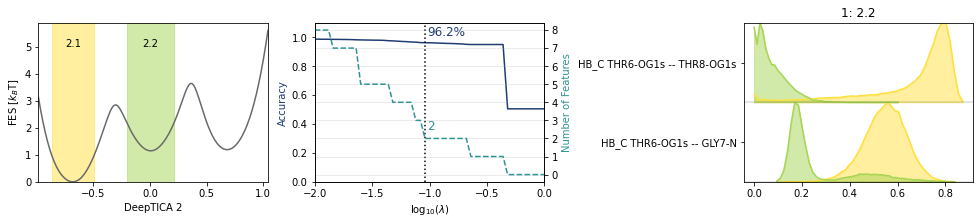

Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:07<00:00,  6.78it/s]
/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/utils/plot.py:398: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Min = cv[mask].min().values[0]
/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/utils/plot.py:399: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Max = cv[mask].max().values[0]


log_10 (lambda) : -0.6
Accuracy        : 100.0 %
No. features    : 1
Basis quality   : 1 (lower the better)
Accuracy: 99%
State 2.3:
 HB_C THR8-OG1s -- TRP9-N


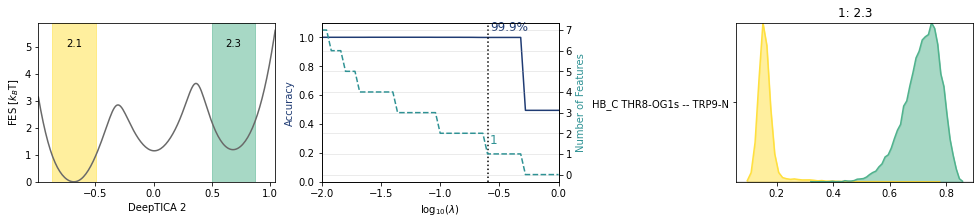

In [15]:
# DeepTICA 2
states_labels = labels_list[1]
states_subset = states_labels['labels'].unique()
states_subset = states_subset[states_subset != 'undefined' ]

cv_level = states_subset[0].count('.')+1
cv_list = [f'DeepTICA {cv_level}']

subset=['2.1','2.2']
colors = [paletteFessa[4],paletteFessa[3]]
result = train(cv_list,desc,states_labels=states_labels,states_subset=subset,color=colors)
results_list.append(result)
plt.show()

subset=['2.1','2.3']
colors = [paletteFessa[4],paletteFessa[2]]
result = train(cv_list,desc,states_labels=states_labels,states_subset=subset,color=colors)
results_list.append(result)
plt.show()

## Visualize features

Here we select the results of the first classification and plot samples of the protein along with the relevant features highlighted

In [12]:
(cv_list,states_labels,features_names,classifier,reg) = results_list[0]
relevant_feat = classifier.feature_summary(reg)

In [13]:
import nglview 
import matplotlib
from stateinterpreter.utils.visualize import compute_residue_score,visualize_protein_features

n_residues = traj.n_residues
residue_score = compute_residue_score(classifier,reg,feats_info,n_residues)

states_subset = states_labels['labels'].unique()
states_subset = states_subset[states_subset != 'undefined' ]

classes_names = classifier.classes

view = visualize_protein_features(traj, states_labels, classes_names, residue_score, representation='ball_and_stick', relevant_features=relevant_feat, features_info=feats_info, all_atoms = False)# , state_frames= [39078, 19992])

view

frames: [39959, 64557]
HB_C TYR1-O -- TYR10-N [22, 144]


NGLWidget(max_frame=1)